<a href="https://colab.research.google.com/github/mj200004/Image-Classification/blob/main/Image-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d erickendric/tree-dataset-of-urban-street-classification-flower

 99% 1.26G/1.27G [00:13<00:00, 105MB/s] 
100% 1.27G/1.27G [00:13<00:00, 104MB/s]


In [ ]:
import zipfile

zip_ref=zipfile.ZipFile('/content/tree-dataset-of-urban-street-classification-flower.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:

training_path = '/content/flower/train'
validation_path = '/content/flower/val'
testing_path = '/content/flower/test'
img_width = 224
img_height = 224
batch_size = 32


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define normalization factor
norm = 255.0

# Define combined ImageDataGenerator with merged techniques
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Data augmentation for validation and testing
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1828 images belonging to 17 classes.
Found 228 images belonging to 17 classes.
Found 219 images belonging to 17 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Aesculus chinensis
1 : Albizia julibrissin
2 : Camptotheca acuminata
3 : Flowering cherry
4 : Koelreuteria paniculata
5 : Lagerstroemia indica
6 : Liriodendron chinense
7 : Loropetalum chinense var. rubrum
8 : Magnolia liliflora Desr
9 : Malushalliana
10 : Nandina domestica
11 : Nerium oleander L
12 : Osmanthus fragrans
13 : Photinia serratifolia
14 : Prunus persica
15 : Rhododendron pulchrum
16 : Styphnolobium japonicum


In [ ]:
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

    # Additional Convolutional Layer
    model.add(Conv2D(256, kernel_size=(3, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Additional Dense Layer
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(17, activation='softmax'))

    return model


In [ ]:
cnn_model = create_model()

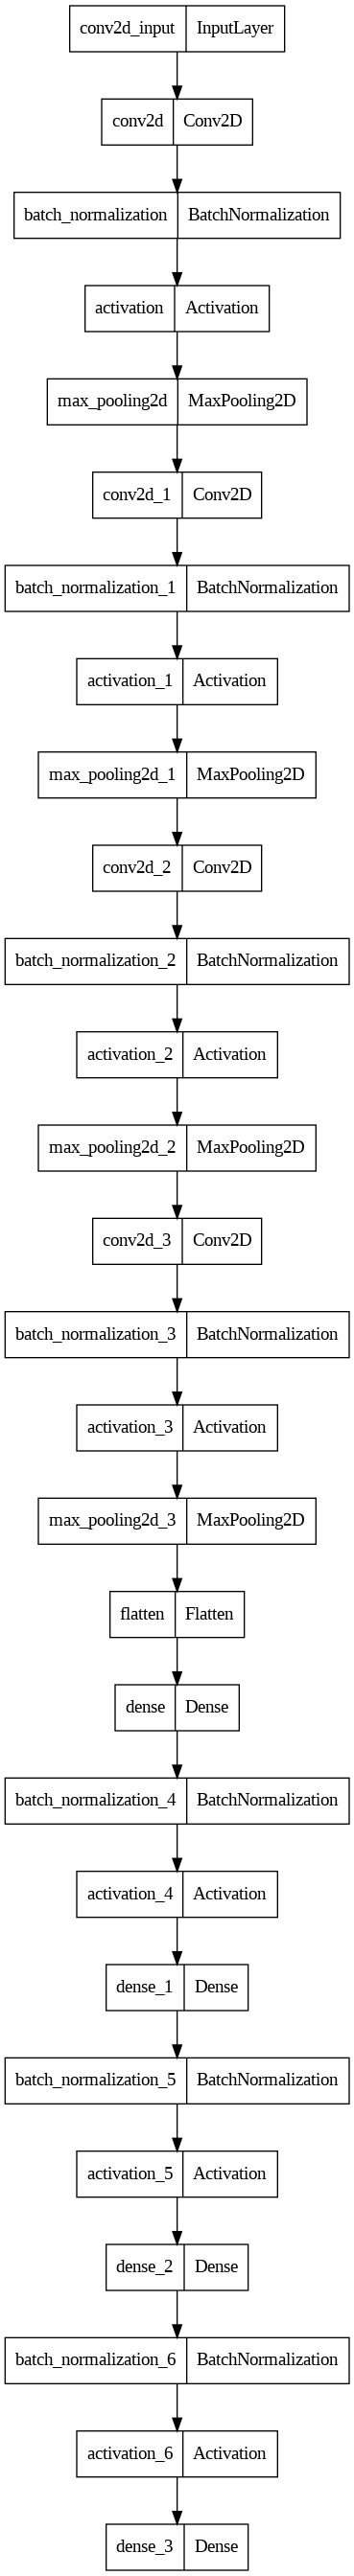

In [ ]:
from keras.utils import plot_model
plot_model(cnn_model)

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.models import Model

def get_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = Dropout(0.5)(base_model.output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='relu')(x)

    x = BatchNormalization()(x)
    predictions = Dense(17, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers: # Freeze the layers of the pre-trained model
        layer.trainable = False

    # Unfreeze some layers for fine-tuning
    for layer in model.layers[:249]:  # Unfreeze the top layers
        layer.trainable = False
    for layer in model.layers[249:]:  # Unfreeze the bottom layers
        layer.trainable = True
    model.summary()
    return model


In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from datetime import datetime as dt

# Pre-trained Model-InceptionV3
model = get_model()

steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

optimizer = Adam()  # Define the optimizer

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_98 (Conv2D)          (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_102 (B  (None, None, None, 32)       96        ['conv2d_98[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_101 (Activation  (None, None, None, 32)       0         ['batch_normalization_10

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
import math

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

In [ ]:

# Create the optimizer with an initial learning rate
initial_learning_rate = 0.01
opt = SGD(learning_rate=initial_learning_rate)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [ ]:

# Compile the model with optimizer, loss, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the number of epochs
epochs = 50

# Fit the model with the training data
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=2,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

<ipython-input-25-1b84c23fbfed>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
58/58 - 352s - loss: 1.3475 - accuracy: 0.6953 - val_loss: 22.3169 - val_accuracy: 0.5351 - 352s/epoch - 6s/step
Epoch 2/50
58/58 - 340s - loss: 0.4678 - accuracy: 0.8720 - val_loss: 0.8862 - val_accuracy: 0.8246 - 340s/epoch - 6s/step
Epoch 3/50
58/58 - 356s - loss: 0.5688 - accuracy: 0.8632 - val_loss: 1.4382 - val_accuracy: 0.7544 - 356s/epoch - 6s/step
Epoch 4/50
58/58 - 344s - loss: 0.3725 - accuracy: 0.9196 - val_loss: 0.5676 - val_accuracy: 0.8772 - 344s/epoch - 6s/step
Epoch 5/50
58/58 - 331s - loss: 0.3034 - accuracy: 0.9196 - val_loss: 0.2715 - val_accuracy: 0.9430 - 331s/epoch - 6s/step
Epoch 6/50
58/58 - 337s - loss: 0.4445 - accuracy: 0.8879 - val_loss: 1.0325 - val_accuracy: 0.8553 - 337s/epoch - 6s/step
Epoch 7/50
58/58 - 335s - loss: 0.2144 - accuracy: 0.9508 - val_loss: 3.7540 - val_accuracy: 0.9079 - 335s/epoch - 6s/step
Epoch 8/50
58/58 - 335s - loss: 0.2348 - accuracy: 0.9404 - val_loss: 0.1570 - val_accuracy: 0.9605 - 335s/epoch - 6s/step
Epoch 9/50
58/5